<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/Extract_Title%2C_Text%2C_Images_%2C_Table%2C_List_from_Documents_(PDFs%2C_Images_etc_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U layoutparser as lp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-5bd6vau1/detectron2_73a017d481e94804af3dd117ab87fc0e
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-5bd6vau1/detectron2_73a017d481e94804af3dd117ab87fc0e
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install layoutparser[ocr]     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [5]:
%cd layout-parser/


/content/layout-parser


In [6]:
%cd examples/data

/content/layout-parser/examples/data


In [7]:
import cv2
image = cv2.imread("paper-image.jpg")
image = image[..., ::-1] 

config.yaml?dl=1: 8.19kB [00:02, 4.06kB/s]
model_final.pth?dl=1: 856MB [00:55, 15.5MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


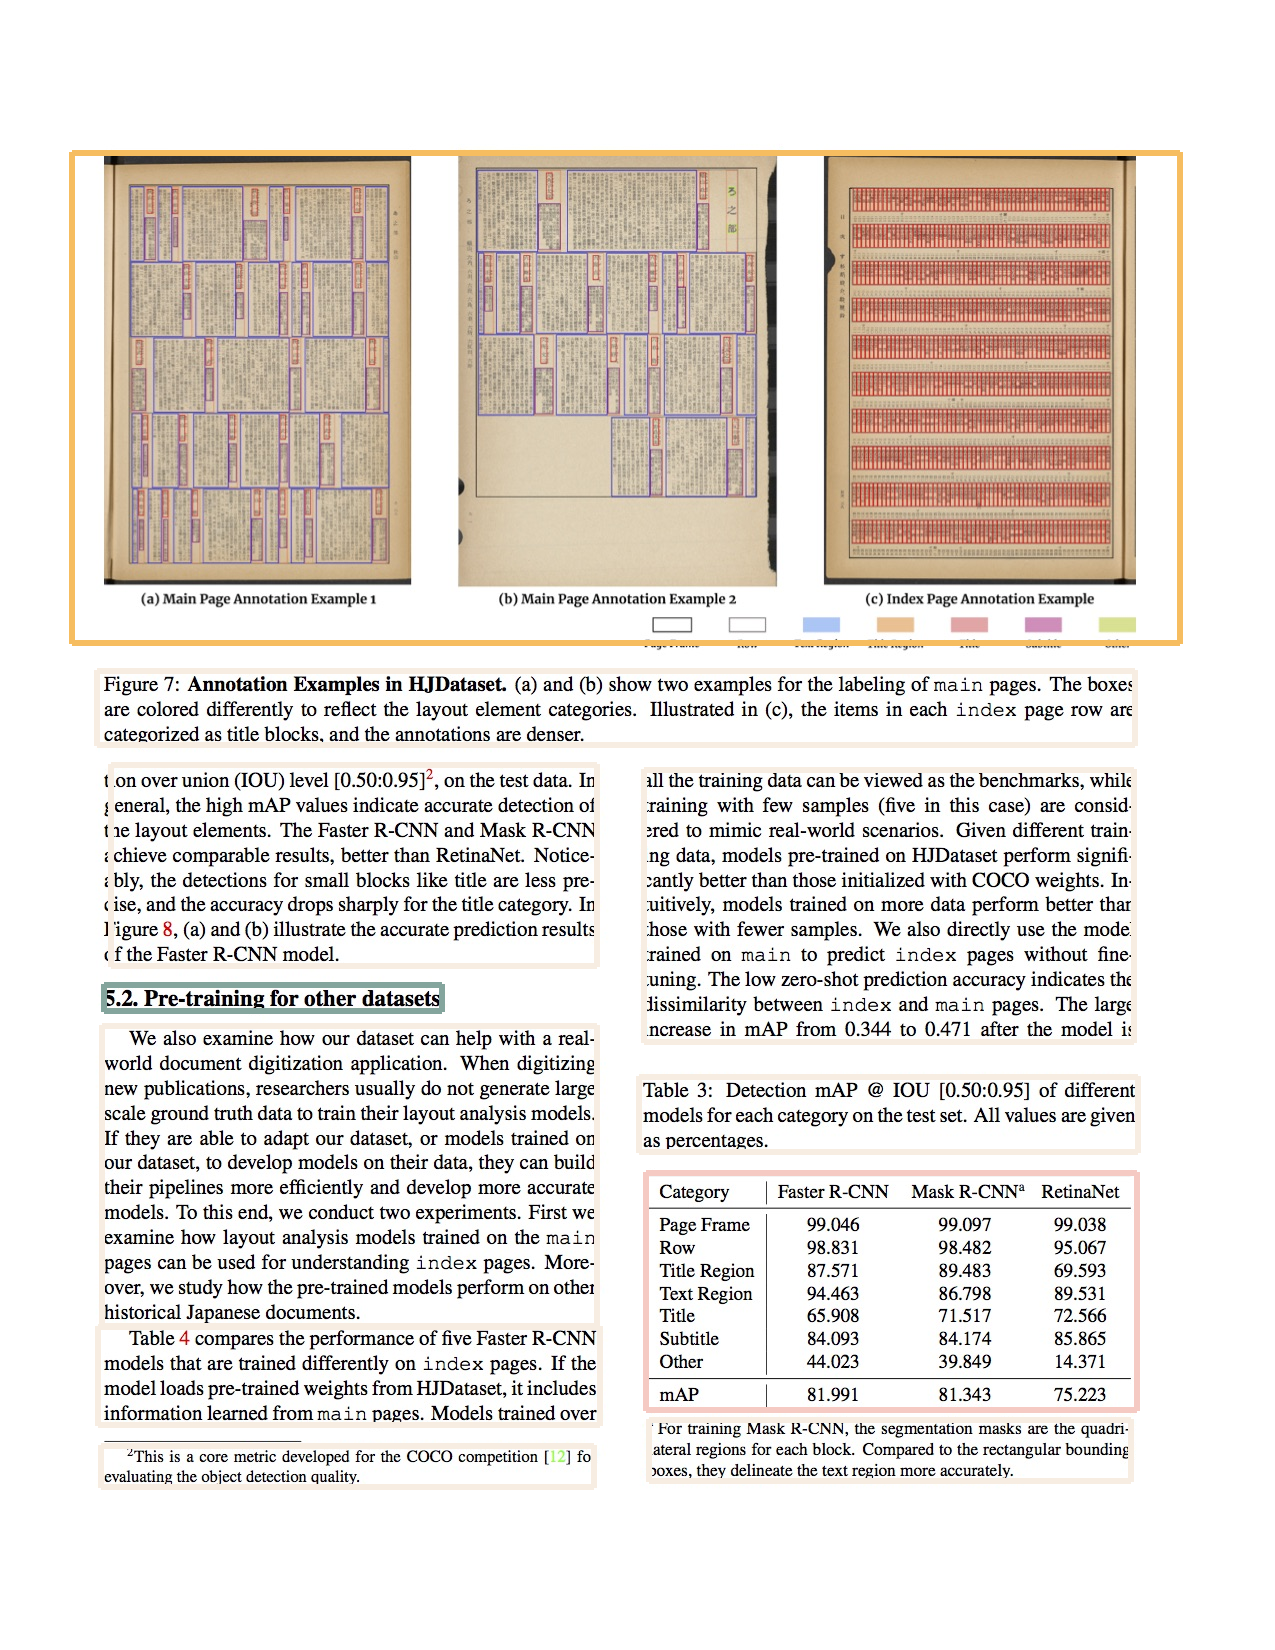

In [9]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [10]:
text_blocks = lp.Layout([b for b in layout if b.type=="Title"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=104.18390655517578, y_1=984.319091796875, x_2=441.5095520019531, y_2=1011.4129638671875), text=None, id=None, type=Title, parent=None, next=None, score=0.987136960029602)], page_data={})

In [11]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [12]:
figure_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=72.3290023803711, y_1=152.1854705810547, x_2=1179.6292724609375, y_2=643.6030883789062), text=None, id=None, type=Figure, parent=None, next=None, score=0.9979682564735413)], page_data={})

In [13]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [14]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

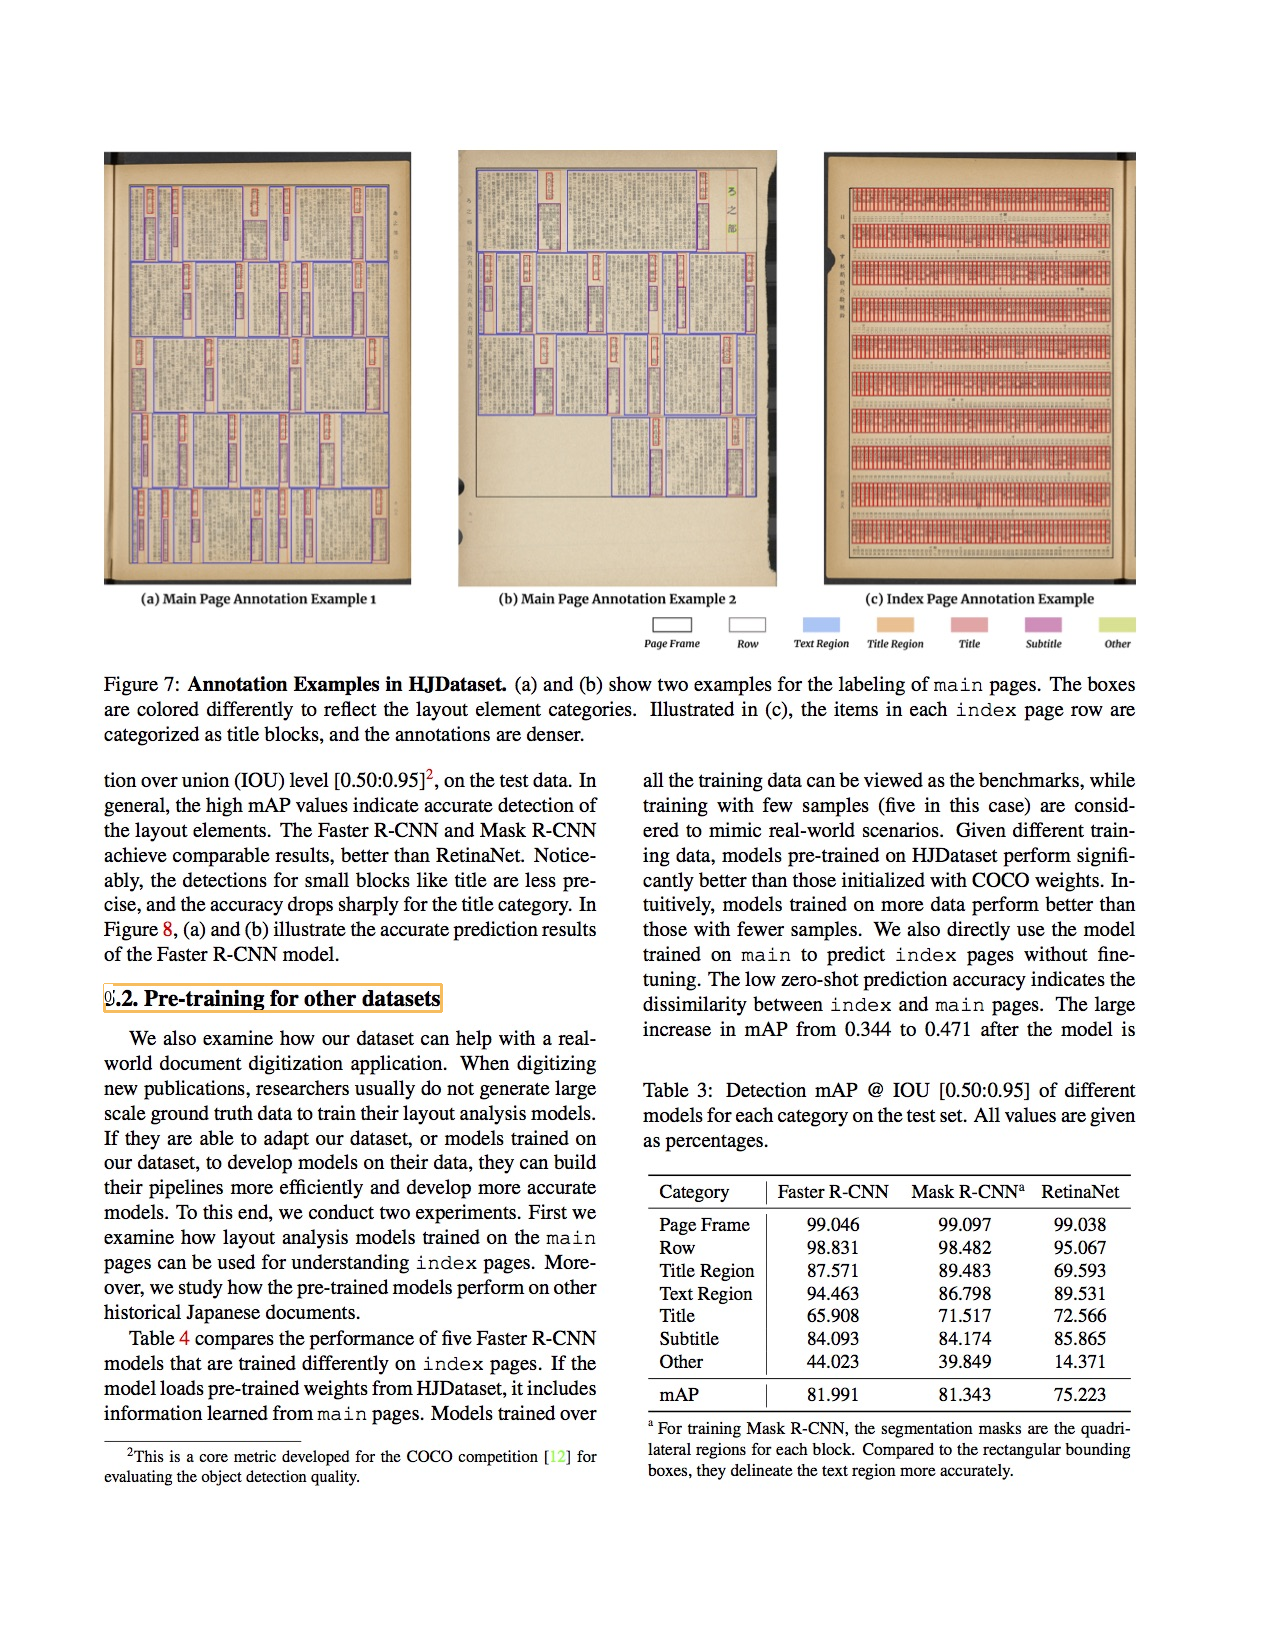

In [15]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [16]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [17]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 3s (1,744 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fro

In [18]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [19]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

5.2. Pre-training for other datasets

---


In [20]:
text_blocks.get_texts()

['5.2. Pre-training for other datasets\n\x0c']

In [21]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=104.18390655517578, y_1=984.319091796875, x_2=441.5095520019531, y_2=1011.4129638671875), text=5.2. Pre-training for other datasets
, id=0, type=Title, parent=None, next=None, score=0.987136960029602)


In [22]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.8/190.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.7 MB/s eta 0:00:00
2023-05-22 21:32:57.092280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 21:32:58.100279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-22 21:32:59.923019: I tensorflow/compiler/xla/stream_exec

In [24]:
!pip install click==7.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.3
    Uninstalling click-8.1.3:
      Successfully uninstalled click-8.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 2.2.4 requires click>=8.0, but you have click 7.1.1 which is incompatible.
pip-tools 6.13.0 requires click>=8, but you have click 7.1.1 which is incompatible.


In [25]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [26]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [27]:
".".join(sentence)  

'5.2. Pre-training for other datasets\n\x0c'

In [28]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

5.2. CARDINAL
